## Pytorch LSTM Based Classification

In [ ]:
#!pip install --quiet torch==1.8.1

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!pip install --quiet pytorch-lightning==1.2.6

In [ ]:
!pip install torchtext==0.8.0 torch==1.7.1 pytorch-lightning==1.2.2

In [80]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import torch 
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


import pytorch_lightning as pl
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator


In [81]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from multiprocessing import cpu_count
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.metrics.functional import accuracy
from sklearn.metrics import classification_report, confusion_matrix


In [82]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE","#FFDD00","#FF7D00","#FF006D","#ADFF02","#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 16,10

In [83]:
pl.seed_everything(42)

Global seed set to 42


42

In [84]:
X_train = pd.read_csv('/content/drive/MyDrive/PAM_AP2_Dataset/X_trn_new.csv')
y_train = pd.read_csv('/content/drive/MyDrive/PAM_AP2_Dataset/y_trn_new.csv')

In [85]:
len(X_train)

796587

In [86]:
len(y_train)

796587

In [ ]:
#y_train = y_train.sample(n=7044,replace=True)

In [89]:
y_train.rename(columns = {'activity_id':'surface'}, inplace = True)

In [88]:
X_train.rename(columns = {'activity_id':'surface'}, inplace = True)

In [90]:
y_train.rename(columns = {'series_id':'id'}, inplace = True)

In [91]:
X_train.rename(columns = {'series_id':'id'}, inplace = True)

In [92]:
X_train.head()

,Unnamed: 0,time_stamp,surface,ankle_3D_acceleration_16_x,ankle_3D_acceleration_16_y,ankle_3D_acceleration_16_z,ankle_3D_acceleration_6_x,ankle_3D_acceleration_6_y,ankle_3D_acceleration_6_z,ankle_3D_gyroscope_x,ankle_3D_gyroscope_y,ankle_3D_gyroscope_z,id
0,154281,1551.19,12,9.75372,-1.04280,-0.835833,9.80851,-1.01234,-0.600316,-0.010195,-0.010306,-0.009147,101
1,154282,1551.20,12,9.78375,-1.19298,-1.066130,9.73352,-1.02744,-0.569598,0.000103,-0.008209,-0.006737,101
2,154283,1551.21,12,9.86120,-1.11816,-0.988621,9.77851,-1.07282,-0.584827,-0.003771,-0.024143,0.008858,101
3,154284,1551.22,12,9.71020,-1.15486,-1.028530,9.77858,-1.04256,-0.569789,-0.009096,0.049125,0.004017,101
4,154285,1551.23,12,9.78246,-1.23063,-1.104500,9.77875,-1.10300,-0.524190,-0.041132,0.005700,0.014554,101


In [93]:
y_train.head()

,Unnamed: 0,Unnamed: 0.1,time_stamp,surface,id
0,0,154281,1551.19,12,101
1,1,154282,1551.20,12,101
2,2,154283,1551.21,12,101
3,3,154284,1551.22,12,101
4,4,154285,1551.23,12,101


In [ ]:
y_train = y_train[['time_stamp', 'surface']]

In [94]:
y_train.head()

,Unnamed: 0,Unnamed: 0.1,time_stamp,surface,id
0,0,154281,1551.19,12,101
1,1,154282,1551.20,12,101
2,2,154283,1551.21,12,101
3,3,154284,1551.22,12,101
4,4,154285,1551.23,12,101


In [95]:
y_train['series_id'] = np.arange(len(y_train))
y_train.head()

,Unnamed: 0,Unnamed: 0.1,time_stamp,surface,id,series_id
0,0,154281,1551.19,12,101,0
1,1,154282,1551.20,12,101,1
2,2,154283,1551.21,12,101,2
3,3,154284,1551.22,12,101,3
4,4,154285,1551.23,12,101,4


In [96]:
first_column = y_train.pop('series_id')
y_train.insert(0, 'series_id', first_column)
y_train.head()

,series_id,Unnamed: 0,Unnamed: 0.1,time_stamp,surface,id
0,0,0,154281,1551.19,12,101
1,1,1,154282,1551.20,12,101
2,2,2,154283,1551.21,12,101
3,3,3,154284,1551.22,12,101
4,4,4,154285,1551.23,12,101


In [97]:
len(y_train)

796587

In [ ]:
y_train.surface.value_counts().plot(kind="bar")
plt.xticks(rotation=45)
plt.show();

## Pre-processing

In [98]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(y_train.surface)

In [99]:
encoded_labels[:50000]

array([3, 3, 3, ..., 0, 0, 0])

In [100]:
label_encoder.classes_

array([ 4,  5,  7, 12, 13, 24])

In [101]:
y_train["label"] = encoded_labels

In [102]:
y_train.head()

,series_id,Unnamed: 0,Unnamed: 0.1,time_stamp,surface,id,label
0,0,0,154281,1551.19,12,101,3
1,1,1,154282,1551.20,12,101,3
2,2,2,154283,1551.21,12,101,3
3,3,3,154284,1551.22,12,101,3
4,4,4,154285,1551.23,12,101,3


In [103]:
y_train.label.value_counts()

0    238761
2    188107
3    117216
4    104944
1     98199
5     49360
Name: label, dtype: int64

In [112]:
y1 = y_train.loc[y_train['label'] == 0].head(1314)
y2 = y_train.loc[y_train['label'] == 1].head(1314)
y3 = y_train.loc[y_train['label'] == 2].head(1314)
y4 = y_train.loc[y_train['label'] == 3].head(1314)
y5 = y_train.loc[y_train['label'] == 4].head(1314)
y6 = y_train.loc[y_train['label'] == 5].head(1317)

In [113]:
y_train = pd.concat([y1, y2, y3, y4, y5, y6],ignore_index=True)

In [114]:
y_train

,series_id,Unnamed: 0,Unnamed: 0.1,time_stamp,surface,id,label
0,30789,30789,223759,2245.97,4,101,0
1,30790,30790,223760,2245.98,4,101,0
2,30791,30791,223761,2245.99,4,101,0
3,30792,30792,223762,2246.00,4,101,0
4,30793,30793,223763,2246.01,4,101,0
...,...,...,...,...,...,...,...
7882,95884,95884,350200,3510.38,24,101,5
7883,95885,95885,350201,3510.39,24,101,5
7884,95886,95886,350202,3510.40,24,101,5
7885,95887,95887,350203,3510.41,24,101,5


In [115]:
y_train = y_train[['time_stamp', 'surface','id','label']]

In [ ]:
y_train['series_id'] = np.arange(len(y_train))
y_train

In [118]:
first_column = y_train.pop('series_id')
y_train.insert(0, 'series_id', first_column)
y_train.head()

,series_id,time_stamp,surface,id,label
0,0,2245.97,4,101,0
1,1,2245.98,4,101,0
2,2,2245.99,4,101,0
3,3,2246.00,4,101,0
4,4,2246.01,4,101,0


In [123]:
y_train.shape

(7887, 5)

In [ ]:
y_train.surface.value_counts().plot(kind="bar")
plt.xticks(rotation=45)
plt.show();

In [129]:
ntimes = 101 # number of times you repeat each item
yourlist = [*range(0, 7887, 1)]
print(len(yourlist))
X_train['series_id'] = [i for i in yourlist for _ in range(ntimes)]

7887


In [130]:
X_train.head()

,Unnamed: 0,time_stamp,surface,ankle_3D_acceleration_16_x,ankle_3D_acceleration_16_y,ankle_3D_acceleration_16_z,ankle_3D_acceleration_6_x,ankle_3D_acceleration_6_y,ankle_3D_acceleration_6_z,ankle_3D_gyroscope_x,ankle_3D_gyroscope_y,ankle_3D_gyroscope_z,id,series_id
0,154281,1551.19,12,9.75372,-1.04280,-0.835833,9.80851,-1.01234,-0.600316,-0.010195,-0.010306,-0.009147,101,0
1,154282,1551.20,12,9.78375,-1.19298,-1.066130,9.73352,-1.02744,-0.569598,0.000103,-0.008209,-0.006737,101,0
2,154283,1551.21,12,9.86120,-1.11816,-0.988621,9.77851,-1.07282,-0.584827,-0.003771,-0.024143,0.008858,101,0
3,154284,1551.22,12,9.71020,-1.15486,-1.028530,9.77858,-1.04256,-0.569789,-0.009096,0.049125,0.004017,101,0
4,154285,1551.23,12,9.78246,-1.23063,-1.104500,9.77875,-1.10300,-0.524190,-0.041132,0.005700,0.014554,101,0


In [132]:
X_train.series_id.value_counts()

2047    101
3234    101
7840    101
5793    101
3746    101
       ... 
2384    101
337     101
6482    101
4435    101
0       101
Name: series_id, Length: 7887, dtype: int64

In [126]:
len(y_train)

7887

In [ ]:
X_train.head()

,Unnamed: 0,time_stamp,ankle_3D_acceleration_16_x,ankle_3D_acceleration_16_y,ankle_3D_acceleration_16_z,ankle_3D_acceleration_6_x,ankle_3D_acceleration_6_y,ankle_3D_acceleration_6_z,ankle_3D_gyroscope_x,ankle_3D_gyroscope_y,ankle_3D_gyroscope_z,series_id
0,154281,1551.19,9.75372,-1.04280,-0.835833,9.80851,-1.01234,-0.600316,-0.010195,-0.010306,-0.009147,0
1,154282,1551.20,9.78375,-1.19298,-1.066130,9.73352,-1.02744,-0.569598,0.000103,-0.008209,-0.006737,0
2,154283,1551.21,9.86120,-1.11816,-0.988621,9.77851,-1.07282,-0.584827,-0.003771,-0.024143,0.008858,0
3,154284,1551.22,9.71020,-1.15486,-1.028530,9.77858,-1.04256,-0.569789,-0.009096,0.049125,0.004017,0
4,154285,1551.23,9.78246,-1.23063,-1.104500,9.77875,-1.10300,-0.524190,-0.041132,0.005700,0.014554,0


In [135]:
FEATURE_COLUMNS = X_train.columns.tolist()[3:11]
FEATURE_COLUMNS

['ankle_3D_acceleration_16_x',
 'ankle_3D_acceleration_16_y',
 'ankle_3D_acceleration_16_z',
 'ankle_3D_acceleration_6_x',
 'ankle_3D_acceleration_6_y',
 'ankle_3D_acceleration_6_z',
 'ankle_3D_gyroscope_x',
 'ankle_3D_gyroscope_y']

In [136]:
X_train.series_id.value_counts()

2047    101
3234    101
7840    101
5793    101
3746    101
       ... 
2384    101
337     101
6482    101
4435    101
0       101
Name: series_id, Length: 7887, dtype: int64

In [140]:
(X_train.series_id.value_counts()==101).sum()

7887

In [139]:
len(y_train)

7887

In [141]:
(X_train.series_id.value_counts()==101).sum() == len(y_train)

True

In [142]:
y_train

,series_id,time_stamp,surface,id,label
0,0,2245.97,4,101,0
1,1,2245.98,4,101,0
2,2,2245.99,4,101,0
3,3,2246.00,4,101,0
4,4,2246.01,4,101,0
...,...,...,...,...,...
7882,7882,3510.38,24,101,5
7883,7883,3510.39,24,101,5
7884,7884,3510.40,24,101,5
7885,7885,3510.41,24,101,5


In [144]:
sequences = []

for series_id, group in X_train.groupby('series_id'):
  sequence_features = group[FEATURE_COLUMNS]
  label = y_train[y_train.series_id == series_id].iloc[0].label

  sequences.append((sequence_features, label))

In [146]:
len(sequences)

7887

In [149]:
sequences[3]

(     ankle_3D_acceleration_16_x  ...  ankle_3D_gyroscope_y
 303                     9.70417  ...             -0.037824
 304                     9.81424  ...              0.000299
 305                     9.89000  ...              0.004408
 306                     9.77812  ...             -0.018066
 307                     9.85466  ...             -0.015011
 ..                          ...  ...                   ...
 399                     9.80685  ...              0.001298
 400                     9.84227  ...             -0.012448
 401                     9.80216  ...             -0.041071
 402                     9.88311  ...              0.003598
 403                     9.87891  ...              0.042157
 
 [101 rows x 8 columns], 0.0)

In [209]:
train_sequences, test_sequences = train_test_split(sequences, test_size=0.50, shuffle = True)

In [210]:
len(train_sequences), len(test_sequences)

(3943, 3944)

In [ ]:
y_train.surface.value_counts().plot(kind="bar")
plt.xticks(rotation=45)
plt.show();

## Dataset

In [211]:
class SurfaceDataset(Dataset):

  def __init__(self, sequences):
    self.sequences = sequences
  
  def __len__(self):
    return len(self.sequences)

  def __getitem__(self, idx):
    sequence, label = self.sequences[idx]
    return dict(
        sequence=torch.Tensor(sequence.to_numpy()),
        label=torch.tensor(label).long()
    )

In [212]:
class SurfaceDataModule(pl.LightningDataModule):

  def __init__(self, train_sequences, test_sequences, batch_size):

    super().__init__()
    self.train_sequences=train_sequences
    self.test_sequences=test_sequences
    self.batch_size=batch_size

  def setup(self, stage = None):
    self.train_dataset = SurfaceDataset(self.train_sequences)
    self.test_dataset = SurfaceDataset(self.test_sequences)

  def train_dataloader(self):
    return DataLoader(
        self.train_dataset,
        batch_size=self.batch_size,
        shuffle=True,
        num_workers=cpu_count()
    )

  def val_dataloader(self):
    return DataLoader(
        self.test_dataset,
        batch_size=self.batch_size,
        shuffle=False,
        num_workers=cpu_count()
    )

  def test_dataloader(self):
    return DataLoader(
        self.test_dataset,
        batch_size=self.batch_size,
        shuffle=False,
        num_workers=cpu_count()
    )




In [213]:
N_EPOCHS = 50
BATCH_SIZE = 64

data_module = SurfaceDataModule(train_sequences, test_sequences, BATCH_SIZE)

## Pytorch LSTM

In [214]:
class SequenceModel(nn.Module):

  def __init__(self, n_features, n_classes, n_hidden=100, n_layers=3):
    super().__init__()

    #self.n_hidden = n_hidden

    self.lstm = nn.LSTM(
        input_size = n_features,
        hidden_size = n_hidden,
        num_layers = n_layers,
        batch_first=True,
        dropout=0.75
    )

    self.classifier = nn.Linear(n_hidden, n_classes)

  def forward(self, x):

    self.lstm.flatten_parameters()
    _, (hidden, _) = self.lstm(x)

    out = hidden[-1]
    return self.classifier(out)

In [216]:
class SurfacePredictor(pl.LightningModule):

  def __init__(self, n_features, n_classes: int):
    super().__init__()
    self.model = SequenceModel(n_features, n_classes)
    self.criterion = nn.CrossEntropyLoss()

  def forward(self, x, labels=None):

    output = self.model(x)
    loss = 0
    if labels is not None:
      loss = self.criterion(output, labels)
    return loss, output

  def training_step(self, batch, batch_idx):
    sequences = batch["sequence"]
    labels = batch['label']
    loss, outputs = self(sequences, labels)
    predictions = torch.argmax(outputs, dim=1)
    step_accuracy = accuracy(predictions, labels)

    self.log("train_loss", loss, prog_bar=True, logger=True)
    self.log("train_accuracy", step_accuracy, prog_bar=True, logger=True)
    return {"loss" : loss, "accuracy" : step_accuracy}

  def validation_step(self, batch, batch_idx):
    sequences = batch["sequence"]
    labels = batch['label']
    loss, outputs = self(sequences, labels)
    predictions = torch.argmax(outputs, dim=1)
    step_accuracy = accuracy(predictions, labels)

    self.log("val_loss", loss, prog_bar=True, logger=True)
    self.log("val_accuracy", step_accuracy, prog_bar=True, logger=True)
    return {"loss" : loss, "accuracy" : step_accuracy}

  def test_step(self, batch, batch_idx):
    sequences = batch["sequence"]
    labels = batch['label']
    loss, outputs = self(sequences, labels)
    predictions = torch.argmax(outputs, dim=1)
    step_accuracy = accuracy(predictions, labels)

    self.log("test_loss", loss, prog_bar=True, logger=True)
    self.log("test_accuracy", step_accuracy, prog_bar=True, logger=True)
    return {"loss" : loss, "accuracy" : step_accuracy}

  def configure_optimizers(self):
    return optim.Adam(self.parameters(), lr = 0.0001)



In [217]:
model = SurfacePredictor(
    n_features = len(FEATURE_COLUMNS),
    n_classes = len(label_encoder.classes_)
)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir ./Lightning_logs

In [218]:
checkpoint_callback = ModelCheckpoint(
    dirpath= 'checkpoints',
    filename='best-checkpoint',
    save_top_k = 1,
    verbose=True,
    monitor="val_loss",
    mode = "min"

)

logger = TensorBoardLogger("Lightning_logs", name="surface")

trainer = pl.Trainer(
    logger = logger,
    checkpoint_callback= checkpoint_callback,
    max_epochs= N_EPOCHS,
    gpus= 0,
    progress_bar_refresh_rate=30

    
)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: Checkpoint directory checkpoints exists and is not empty.
  warnings.warn(*args, **kwargs)
GPU available: False, used: False
TPU available: None, using: 0 TPU cores


In [219]:
trainer.fit(model, data_module)


  | Name      | Type             | Params
-----------------------------------------------
0 | model     | SequenceModel    | 206 K 
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
206 K     Trainable params
0         Non-trainable params
206 K     Total params
0.825     Total estimated model params size (MB)


Epoch 0, global step 61: val_loss reached 1.79000 (best 1.79000), saving model to "/content/checkpoints/best-checkpoint-v3.ckpt" as top 1


Epoch 1, global step 123: val_loss reached 1.78274 (best 1.78274), saving model to "/content/checkpoints/best-checkpoint-v3.ckpt" as top 1


Epoch 2, global step 185: val_loss reached 1.74291 (best 1.74291), saving model to "/content/checkpoints/best-checkpoint-v3.ckpt" as top 1


Epoch 3, global step 247: val_loss reached 1.57841 (best 1.57841), saving model to "/content/checkpoints/best-checkpoint-v3.ckpt" as top 1


Epoch 4, global step 309: val_loss reached 1.41993 (best 1.41993), saving model to "/content/checkpoints/best-checkpoint-v3.ckpt" as top 1


Epoch 5, global step 371: val_loss reached 1.26354 (best 1.26354), saving model to "/content/checkpoints/best-checkpoint-v3.ckpt" as top 1


Epoch 6, global step 433: val_loss reached 1.21611 (best 1.21611), saving model to "/content/checkpoints/best-checkpoint-v3.ckpt" as top 1


Epoch 7, global step 495: val_loss reached 1.13849 (best 1.13849), saving model to "/content/checkpoints/best-checkpoint-v3.ckpt" as top 1


Epoch 8, global step 557: val_loss reached 1.11555 (best 1.11555), saving model to "/content/checkpoints/best-checkpoint-v3.ckpt" as top 1


Epoch 9, global step 619: val_loss reached 1.09567 (best 1.09567), saving model to "/content/checkpoints/best-checkpoint-v3.ckpt" as top 1


Epoch 10, global step 681: val_loss reached 1.01821 (best 1.01821), saving model to "/content/checkpoints/best-checkpoint-v3.ckpt" as top 1


Epoch 11, global step 743: val_loss reached 1.00272 (best 1.00272), saving model to "/content/checkpoints/best-checkpoint-v3.ckpt" as top 1


Epoch 12, global step 805: val_loss reached 0.99154 (best 0.99154), saving model to "/content/checkpoints/best-checkpoint-v3.ckpt" as top 1


Epoch 13, global step 867: val_loss reached 0.97264 (best 0.97264), saving model to "/content/checkpoints/best-checkpoint-v3.ckpt" as top 1


Epoch 14, global step 929: val_loss reached 0.94954 (best 0.94954), saving model to "/content/checkpoints/best-checkpoint-v3.ckpt" as top 1


Epoch 15, global step 991: val_loss reached 0.90507 (best 0.90507), saving model to "/content/checkpoints/best-checkpoint-v3.ckpt" as top 1


Epoch 16, step 1053: val_loss was not in top 1


Epoch 17, global step 1115: val_loss reached 0.87202 (best 0.87202), saving model to "/content/checkpoints/best-checkpoint-v3.ckpt" as top 1


Epoch 18, global step 1177: val_loss reached 0.83659 (best 0.83659), saving model to "/content/checkpoints/best-checkpoint-v3.ckpt" as top 1


Epoch 19, step 1239: val_loss was not in top 1


Epoch 20, global step 1301: val_loss reached 0.77100 (best 0.77100), saving model to "/content/checkpoints/best-checkpoint-v3.ckpt" as top 1


Epoch 21, step 1363: val_loss was not in top 1


Epoch 22, global step 1425: val_loss reached 0.76057 (best 0.76057), saving model to "/content/checkpoints/best-checkpoint-v3.ckpt" as top 1


Epoch 23, global step 1487: val_loss reached 0.74494 (best 0.74494), saving model to "/content/checkpoints/best-checkpoint-v3.ckpt" as top 1


Epoch 24, global step 1549: val_loss reached 0.68078 (best 0.68078), saving model to "/content/checkpoints/best-checkpoint-v3.ckpt" as top 1


Epoch 25, step 1611: val_loss was not in top 1


Epoch 26, global step 1673: val_loss reached 0.65860 (best 0.65860), saving model to "/content/checkpoints/best-checkpoint-v3.ckpt" as top 1


Epoch 27, step 1735: val_loss was not in top 1


Epoch 28, global step 1797: val_loss reached 0.63004 (best 0.63004), saving model to "/content/checkpoints/best-checkpoint-v3.ckpt" as top 1


Epoch 29, step 1859: val_loss was not in top 1


Epoch 30, step 1921: val_loss was not in top 1


Epoch 31, global step 1983: val_loss reached 0.58901 (best 0.58901), saving model to "/content/checkpoints/best-checkpoint-v3.ckpt" as top 1


Epoch 32, global step 2045: val_loss reached 0.57973 (best 0.57973), saving model to "/content/checkpoints/best-checkpoint-v3.ckpt" as top 1


Epoch 33, global step 2107: val_loss reached 0.56009 (best 0.56009), saving model to "/content/checkpoints/best-checkpoint-v3.ckpt" as top 1


Epoch 34, step 2169: val_loss was not in top 1


Epoch 35, global step 2231: val_loss reached 0.55689 (best 0.55689), saving model to "/content/checkpoints/best-checkpoint-v3.ckpt" as top 1


Epoch 36, global step 2293: val_loss reached 0.50732 (best 0.50732), saving model to "/content/checkpoints/best-checkpoint-v3.ckpt" as top 1


Epoch 37, step 2355: val_loss was not in top 1


Epoch 38, step 2417: val_loss was not in top 1


Epoch 39, step 2479: val_loss was not in top 1


Epoch 40, global step 2541: val_loss reached 0.47507 (best 0.47507), saving model to "/content/checkpoints/best-checkpoint-v3.ckpt" as top 1


Epoch 41, step 2603: val_loss was not in top 1


Epoch 42, step 2665: val_loss was not in top 1


Epoch 43, step 2727: val_loss was not in top 1


Epoch 44, step 2789: val_loss was not in top 1


Epoch 45, global step 2851: val_loss reached 0.45777 (best 0.45777), saving model to "/content/checkpoints/best-checkpoint-v3.ckpt" as top 1


Epoch 46, global step 2913: val_loss reached 0.45568 (best 0.45568), saving model to "/content/checkpoints/best-checkpoint-v3.ckpt" as top 1


Epoch 47, step 2975: val_loss was not in top 1


Epoch 48, step 3037: val_loss was not in top 1


Epoch 49, global step 3099: val_loss reached 0.44468 (best 0.44468), saving model to "/content/checkpoints/best-checkpoint-v3.ckpt" as top 1


1

In [220]:
trainer.test()


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': 0.7749999761581421,
 'loss': 0.4930662512779236,
 'test_accuracy': 0.8354462385177612,
 'test_loss': 0.444681316614151}
--------------------------------------------------------------------------------


[{'accuracy': 0.7749999761581421,
  'loss': 0.4930662512779236,
  'test_accuracy': 0.8354462385177612,
  'test_loss': 0.444681316614151}]

## Predictions

In [221]:
trained_model = SurfacePredictor.load_from_checkpoint(
    trainer.checkpoint_callback.best_model_path,
    n_features=len(FEATURE_COLUMNS),
    n_classes= len(label_encoder.classes_)
)

trained_model.freeze()

In [222]:
test_dataset = SurfaceDataset(test_sequences)

predictions = []
labels = []

for item in tqdm(test_dataset):

  sequence= item["sequence"]
  label = item["label"]

  _, output = trained_model(sequence.unsqueeze(dim=0))
  prediction = torch.argmax(output, dim=1)
  predictions.append(prediction.item())
  labels.append(label.item())


In [223]:
def show_confusion_matrix(confusion_matrix):

  hmap = sns.heatmap(confusion_matrix, annot=True, fmt= "d", cmap= "Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation= 0, ha = 'right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation= 30, ha = 'right')
  plt.ylabel('Excepted Activity')
  plt.xlabel('Predicted Activity');

In [224]:
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score

In [225]:
print("Accuracy:", metrics.accuracy_score(labels, predictions))

Accuracy: 0.835446247464503


In [226]:
print("Precision:", metrics.precision_score(labels, predictions, average='macro'))

Precision: 0.8429875192314867


In [227]:
print("Recall:", metrics.recall_score(labels, predictions,average='macro'))

Recall: 0.8350390322951498


In [228]:
cm = confusion_matrix(labels, predictions)
df_cm = pd.DataFrame(
    cm, index= label_encoder.classes_, columns=label_encoder.classes_
)
df_cm

,4,5,7,12,13,24
4,620,27,27,8,1,0
5,73,463,111,9,2,0
7,18,6,560,53,21,2
12,14,2,29,573,31,5
13,17,0,2,60,543,28
24,2,7,9,6,79,536


In [229]:
cm = confusion_matrix(labels, predictions)
df_cm = pd.DataFrame(
    cm, index= ['Walking','Running','Nordic Walking','Ascending Stairs','Descending Stairs','Rope Jumping'], columns=['Walking','Running','Nordic Walking','Ascending Stairs','Descending Stairs','Rope Jumping']
)
df_cm

,Walking,Running,Nordic Walking,Ascending Stairs,Descending Stairs,Rope Jumping
Walking,620,27,27,8,1,0
Running,73,463,111,9,2,0
Nordic Walking,18,6,560,53,21,2
Ascending Stairs,14,2,29,573,31,5
Descending Stairs,17,0,2,60,543,28
Rope Jumping,2,7,9,6,79,536


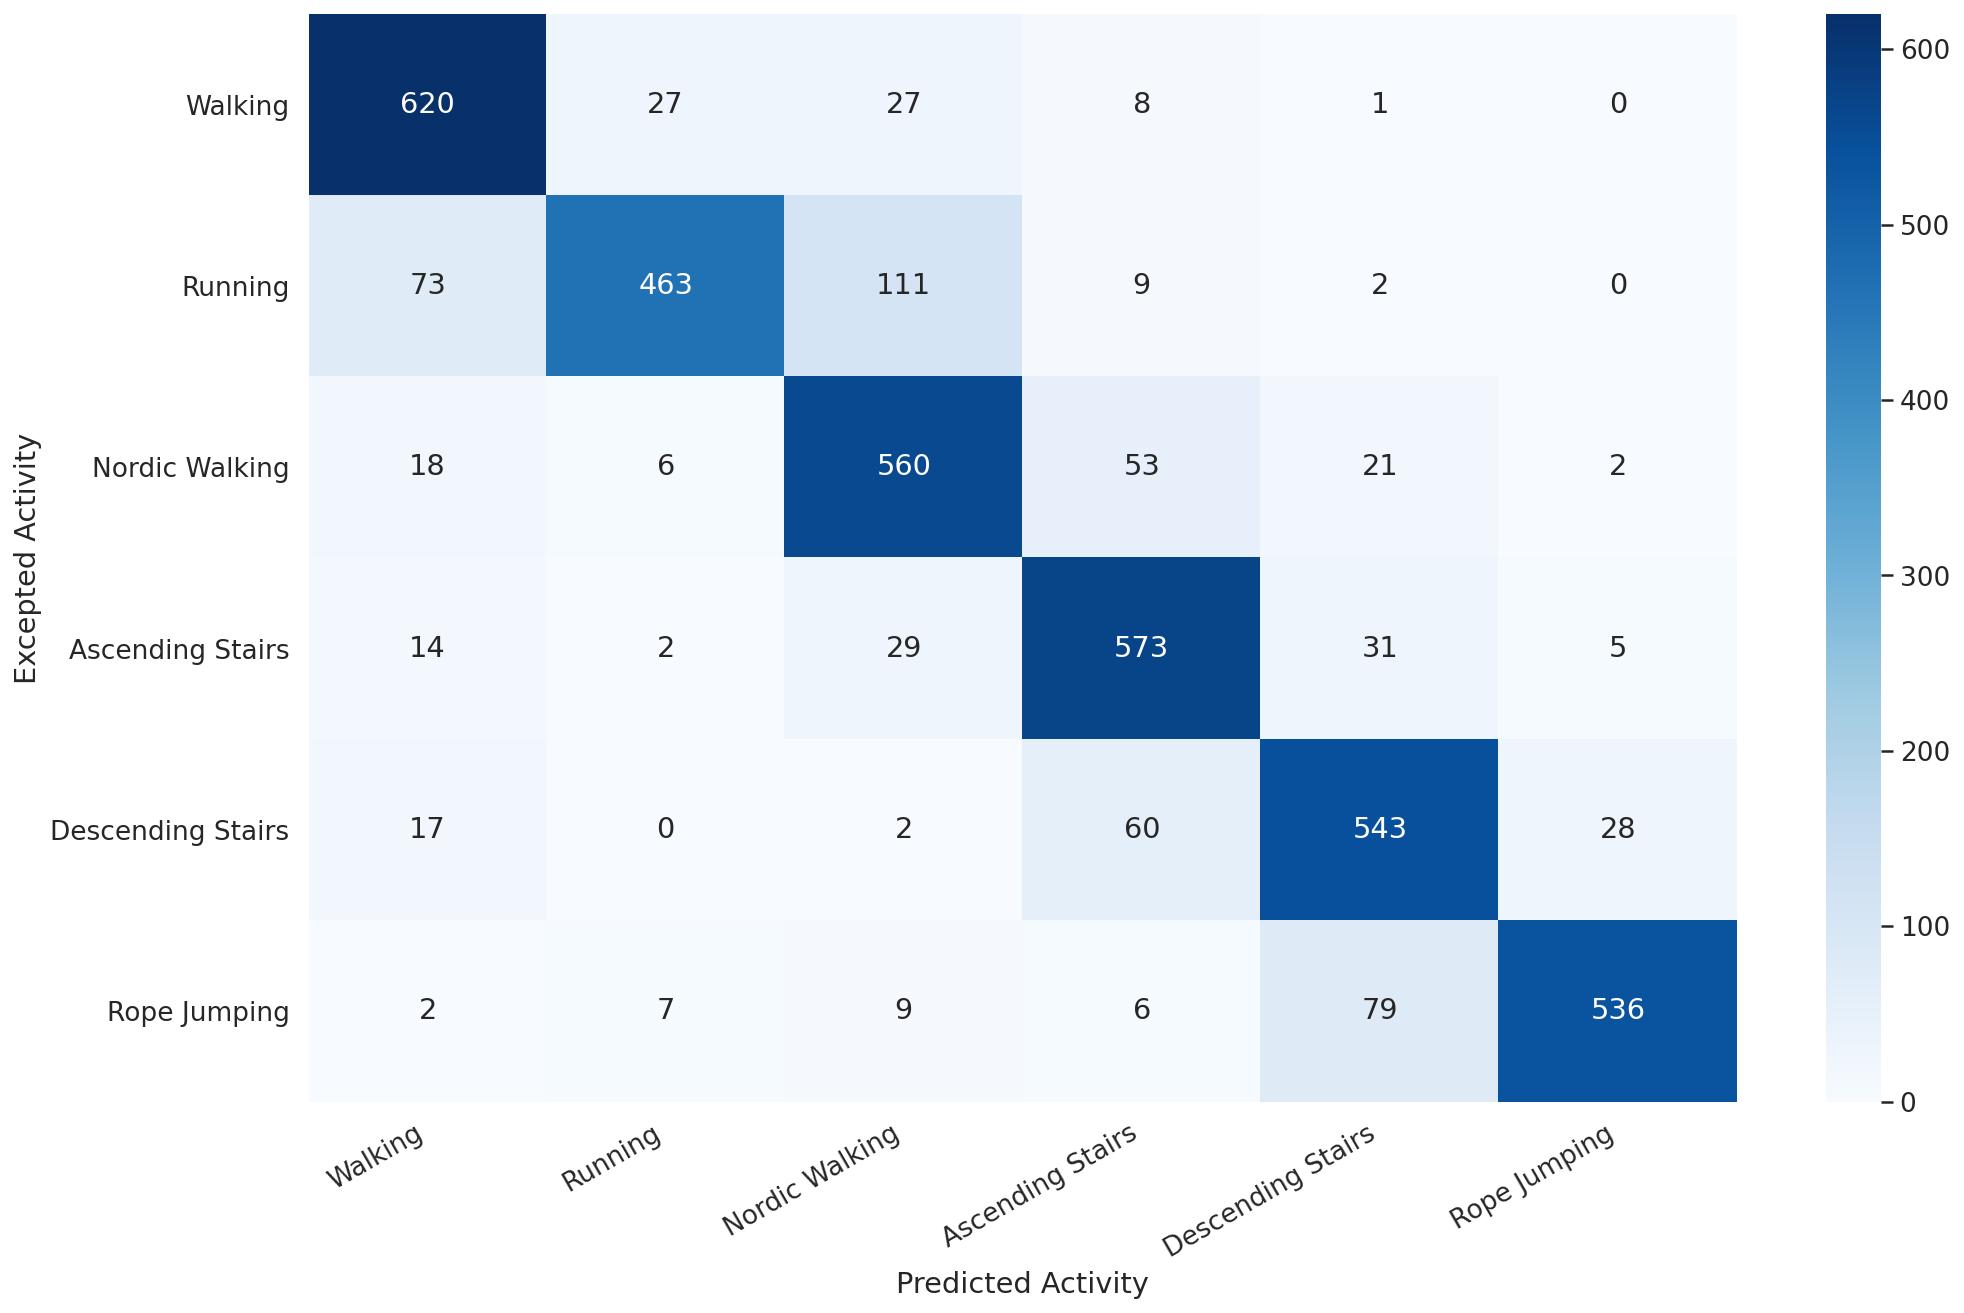

In [230]:
show_confusion_matrix(df_cm)